In [1297]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import *
from functorch import vmap
from IPython.display import display, clear_output
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

# Soft-Nearest-Neighbors definition
### Base idea
----

K-Nearest-Neighbor is an interesting model for various reasons. For instance, out-of-distribution detection is difficult without access to the distribution from which the training data was derived. In KNN, OOD techniques can estimate the distribution through the support dataset carried with the deployed model. Howerver, KNN heavily suffers from the curse-of-dimensionality. This limitation can be solved by learning distance metrics optimal for a particular support dataset. So, this is what this notebook shows. A proof-of-concept in which a NN is used to learn a distance metric $\kappa : X \rightarrow \mathbb{R}.$

----

In [1298]:
def weights(x, X, enc, sim, norm):
    support = enc(X)
    repr = enc(x.view(1, -1))[0]
    k = vmap(lambda prot: sim(repr, prot))(support).view(-1)
    k = norm(k)
    p = F.softmax(k, dim=0)
    return p

### Reality check
----

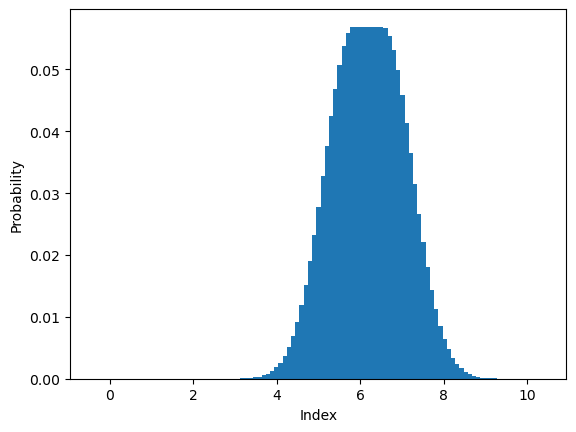

In [1299]:
X = th.linspace(0., 10., 100).view(-1, 1)
x = th.tensor([[6.2]])
w = weights(x, X, enc=lambda x: x, sim=lambda a, b: -(a - b) ** 2, norm=lambda k: k)
plt.bar(X.view(-1), w)
plt.ylabel('Probability')
plt.xlabel('Index')
plt.show()

----

In [1300]:
def _xtoy(x, X, Y, enc, sim, norm):
    w = weights(x, X, enc, sim=sim, norm=norm).view(-1, 1)
    y = (w * Y).sum(dim=0)[0]
    return y

### Reality check
----

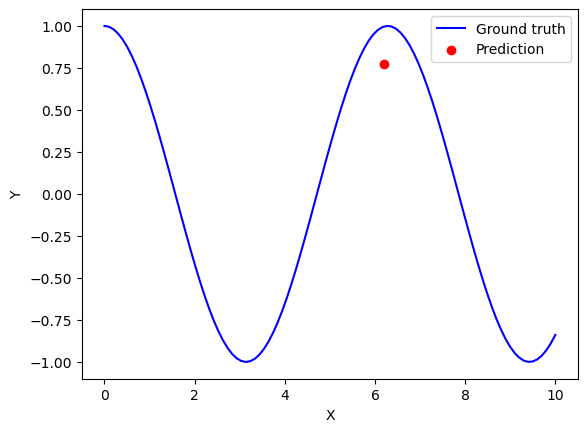

In [1301]:
Y = th.cos(X)
y_pred = _xtoy(x, X, Y, enc=lambda x: x, sim=lambda a, b: -(a - b) ** 2, norm=lambda k: k)
plt.plot(X.view(-1), Y.view(-1), color='blue', label='Ground truth')
plt.scatter(x.view(-1), y_pred, color='red', label='Prediction')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

----

In [1302]:
def snn(X, X_support, Y_support, enc, sim, norm = lambda k: k):
    return vmap(lambda x: _xtoy(x, X_support, Y_support, enc, sim=sim, norm=norm))(X)

### Reality check
----

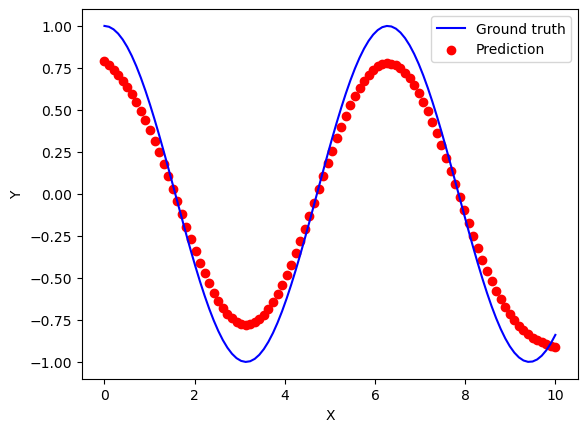

In [1303]:
Y_pred = snn(X, X, Y, enc=lambda x: x, sim=lambda a, b: -(a - b) ** 2, norm=lambda k: k)
plt.plot(X.view(-1), Y.view(-1), color='blue', label='Ground truth')
plt.scatter(X.view(-1), Y_pred.view(-1), color='red', label='Prediction')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

----

# Encoder definition
----
----

In [1304]:
class Dense(nn.Module):
    def __init__(self, in_size, hidden_size):
        super().__init__()
        self.linear = nn.Linear(in_size, hidden_size)

    def forward(self, x):
        h = self.linear(x)
        return th.cat([x, h], dim=1)

In [1305]:
encoder = nn.Sequential(Dense(1, 10), nn.Mish(),
                        Dense(11, 10), nn.Mish(),
                        Dense(21, 10), nn.Mish(),
                        Dense(31, 10), nn.Mish(),
                        nn.Linear(41, 100))

# Problem definition
----
----

In [1306]:
def generate_data(f, N, x_min=-1, x_max=1):
    X = th.rand(N, 1) * (x_max - x_min) + x_min
    Y = f(X)
    return X, Y

In [1307]:
class DatasetWrapper(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

In [1308]:
# Domain and function
x_min = 0.; x_max = 10.; resolution = 1000
fn = lambda x: th.cos(x)

In [1309]:
# Input domain
X_domain = th.linspace(x_min, x_max, resolution).view(-1, 1)

### Sample support dataset
----

In [1322]:
# Support dataset
X_support, Y_support = generate_data(fn, 50, x_min, x_max)

----

### Sample training dataset
----

In [1311]:
# Training dataset
X_training, Y_training = generate_data(fn, 100, x_min, x_max)
dataset = DatasetWrapper(X_training, Y_training)

----

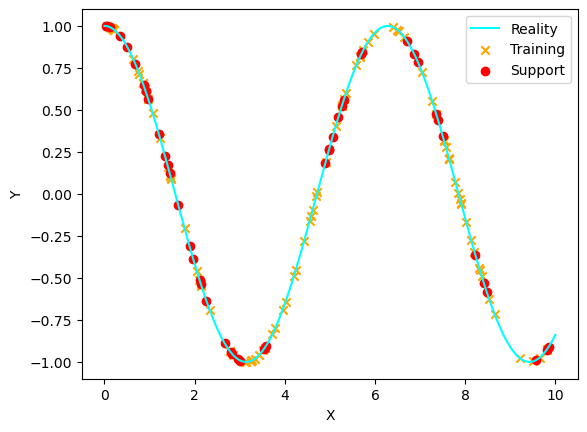

In [1323]:
# Plots
plt.plot(X_domain.view(-1), fn(X_domain), label='Reality', color='cyan')
plt.scatter(X_training.view(-1), Y_training.view(-1), label='Training', color='orange', marker='x')
plt.scatter(X_support.view(-1), Y_support.view(-1), label='Support', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Model fitting
----
----

In [1313]:
def optimize(model, loader, optim, criterion, epochs):
    for epoch in range(epochs):
        batch_loss = None
        optim.zero_grad()
        for (X, Y) in loader:
            Y_pred = model(X)
            loss = criterion(Y_pred, Y) / len(loader)
            batch_loss = loss if batch_loss is None else batch_loss + loss
        batch_loss.backward()
        optim.step()
        clear_output(wait=True)
        print('Epoch [%d], Loss: %.6f' % (epoch + 1, batch_loss))

In [1314]:
def normalize(x):
    return x / x.flatten().shape[0]

In [1315]:
def similarity(a, b):
    return th.dot(a, b)

In [1316]:
predictor = lambda X: snn(X,
                          X_support,
                          Y_support,
                          enc=encoder,
                          sim=similarity,
                          norm=normalize)

### Optimize
----

In [1317]:
optimize(predictor, dataset, Rprop(encoder.parameters()), F.mse_loss, 100)

Epoch [100], Loss: 0.004827


----

Loss: 0.602142


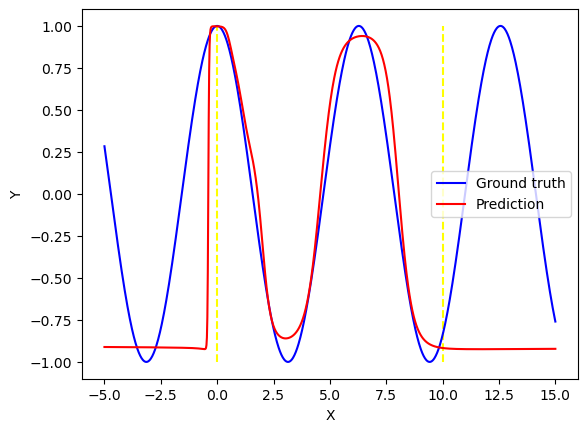

In [1324]:
X = th.linspace(x_min - 5, x_max + 5, resolution).view(-1, 1)
Y = fn(X)
Y_pred = predictor(X).detach()
plt.vlines([x_min, x_max], ymin=Y.view(-1).min(), ymax=Y.view(-1).max(), color='yellow', linestyle='--')
plt.plot(X.view(-1), Y.view(-1), color='blue', label='Ground truth')
plt.plot(X.view(-1), Y_pred.view(-1), color='red', label='Prediction')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
print('Loss: %.6f' % F.mse_loss(Y.view(-1), Y_pred))
plt.show()